In [1]:
data_path = './input'
output_path = './output'

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


./input/tgt-dev.txt
./input/DatasetComplet.xlsx
./input/question_labels.csv
./input/tgt-train-class.csv
./input/tgt-test.txt
./input/verbs.txt
./input/questions_multi_classification.csv
./input/.ipynb_checkpoints/question_labels-checkpoint.csv
./input/.ipynb_checkpoints/verbs-checkpoint.txt
./input/.ipynb_checkpoints/tgt-train-class-checkpoint.csv
./input/.ipynb_checkpoints/questions_multi_classification-checkpoint.csv
./input/verbs/Evaluating.csv
./input/verbs/Understanding.csv
./input/verbs/Analyzing.csv
./input/verbs/Creating.csv
./input/verbs/Remembering.csv
./input/verbs/Applying.csv
./input/verbs/.ipynb_checkpoints/Remembering-checkpoint.csv


In [3]:
import os
import sys
import pickle
import helpers as h
from sentence_transformers import SentenceTransformer, util, models
from torch import nn
import scipy.spatial
from matplotlib import pyplot as plt

In [4]:
df = pd.read_csv("./output/queries_df.csv")
df.head()

,QUERY,REMEMBERING,UNDERSTANDING,APPLYING,ANALYZING,EVALUATING,CREATING
0,"""their own language"" means _ .",1.0,0.0,0.0,0.0,0.0,0.0
1,"""you may think the popular singer jay chow is ...",0.0,1.0,0.0,0.0,0.0,0.0
2,". at midnight, nasreddin saw _ in his garden.",1.0,0.0,0.0,0.0,0.0,0.0
3,. david beckham is _ years old.,1.0,0.0,0.0,0.0,0.0,0.0
4,. david beckham's family name is _ and zhou...,1.0,0.0,0.0,0.0,0.0,0.0


In [5]:
categories = df.columns[1:]
def predict(df_paraphrase:pd.DataFrame, cols = categories):
    if cols is None:
        cols = df_paraphrase.columns
    preds = df_paraphrase[cols].ge(np.max(df_paraphrase[cols].values, axis=1), axis=0)
    preds["PREDICT"] = cols[np.argmax(preds.values, axis=1)]
    return preds

In [6]:
queries = predict(df)
queries.head()

,REMEMBERING,UNDERSTANDING,APPLYING,ANALYZING,EVALUATING,CREATING,PREDICT
0,True,False,False,False,False,False,REMEMBERING
1,False,True,False,False,False,False,UNDERSTANDING
2,True,False,False,False,False,False,REMEMBERING
3,True,False,False,False,False,False,REMEMBERING
4,True,False,False,False,False,False,REMEMBERING


In [7]:
queries["QUERY"] = df["QUERY"]
queries = queries[["QUERY", "PREDICT"]]
queries.sample(5)

,QUERY,PREDICT
34259,is the hydrogen atom the smallest atom ?,REMEMBERING
13999,can you make your own man-made elements ?,EVALUATING
175492,"if a hydrogen atom is neutral , why does n't i...",APPLYING
106340,why does current flow from the positive termin...,ANALYZING
151032,how do you calculate the common denominator ?,ANALYZING


In [8]:
queries.PREDICT.value_counts()

CREATING         55286
REMEMBERING      45873
ANALYZING        39990
APPLYING         23453
EVALUATING       16677
UNDERSTANDING     8520
Name: PREDICT, dtype: int64

In [10]:
np.random.seed(41)
queries.index.name = "Id"
data =  queries["PREDICT"].reset_index(   # need to keep the index as a column
        ).groupby(["PREDICT"]                  # split by "group"
        ).apply(lambda x: x.sample(3000) # in each group, do the random split of 3000
        ).reset_index(drop=True              # index now is group id - reset it
        ).set_index("Id")
data = queries.loc[data.index]
data.head()

,QUERY,PREDICT
Id,,
24644,how do you figure out what numbers a principle...,ANALYZING
11921,its speed can be measured with precision 1 % ....,ANALYZING
113156,"hi , can theta be the angle abc instead of bac ?",ANALYZING
34985,is diffusion and osmosis used by the body syst...,ANALYZING
82841,what is the difference between interior and ex...,ANALYZING


In [10]:
from IPython.display import display

In [11]:
np.random.seed(41)
# queries.index.name = "Id"
train =  data["PREDICT"].reset_index(   # need to keep the index as a column
        ).groupby(["PREDICT"]                  # split by "group"
        ).apply(lambda x: x.sample(frac=0.75) # in each group, do the random split
        ).reset_index(drop=True              # index now is group id - reset it
        ).set_index("Id")
test = data.drop(train.index)
train = data.loc[train.index]

In [12]:
train.head()

,QUERY,PREDICT
Id,,
97013,how do you find the interquartile range in a b...,ANALYZING
95386,why does sal multiply the infinite series by r...,ANALYZING
127950,where does the `` 1/2 '' come from ?,ANALYZING
39586,does the liver actually produce protein or pro...,ANALYZING
20149,why does n't it just directly move through the...,ANALYZING


In [13]:
tmp =  train["PREDICT"].reset_index(   # need to keep the index as a column
        ).groupby(["PREDICT"]                  # split by "group"
        ).apply(lambda x: x.sample(frac=0.8) # in each group, do the random split
        ).reset_index(drop=True              # index now is group id - reset it
        ).set_index("Id")
valid = train.drop(tmp.index)
train = train.loc[tmp.index]
del tmp

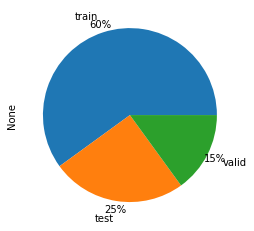

In [14]:
pd.Series([train.shape[0], test.shape[0], valid.shape[0]], index=["train", "test", "valid"]).plot.pie(autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torchtext import data
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

In [16]:
# Set random seed and set device to GPU.
torch.manual_seed(17)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')
print(device)

cuda:0


In [17]:
# Initialize tokenizer.
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [18]:
train.columns

Index(['QUERY', 'PREDICT'], dtype='object')

In [19]:
# Set tokenizer hyperparameters.
MAX_SEQ_LEN = 256
BATCH_SIZE = 16
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)


# Define columns to read.
label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)

In [20]:
fields = [('QUERY', text_field), ('PREDICT', label_field)]

In [21]:
class_replace = {j:i for i,j in enumerate(categories)}
class_replace

{'REMEMBERING': 0,
 'UNDERSTANDING': 1,
 'APPLYING': 2,
 'ANALYZING': 3,
 'EVALUATING': 4,
 'CREATING': 5}

In [22]:
train.PREDICT.replace(class_replace, inplace=True)
test.PREDICT.replace(class_replace, inplace=True)
valid.PREDICT.replace(class_replace, inplace=True)

train.head()

,QUERY,PREDICT
Id,,
175901,so how does a 2.25 inch limestone sculpture ge...,3
74308,"what is the difference between voltage , poten...",3
54140,why keep the 1/2 and ad ?,3
91615,"what are some examples of size-exchange , chro...",3
105616,how do make a negative number into a percent ?,3


In [23]:
from torchtext import data

class DataFrameDataset(data.Dataset):
    def __init__(self, df, text_field, label_field, is_test=False, **kwargs):
        fields = [('QUERY', text_field), ('PREDICT', label_field)]
        examples = []
        for i, row in df.iterrows():
            label = row.PREDICT if not is_test else None
            text = row.QUERY
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.QUERY)

    @classmethod
    def splits(cls, text_field, label_field, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)

        if train_df is not None:
            train_data = cls(train_df.copy(), text_field, label_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), text_field, label_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), text_field, label_field, True, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

In [24]:
train_ds, val_ds, test_ds = DataFrameDataset.splits(
  text_field=text_field, label_field=label_field, train_df=train, val_df=valid, test_df=test)

In [25]:
# Test iterator, no shuffling or sorting required.
train_iter = BucketIterator(train_ds, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=True)
valid_iter = BucketIterator(val_ds, batch_size=BATCH_SIZE, device=device, train=False, shuffle=True, sort=True)
test_iter = Iterator(test_ds, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [26]:
len(train_iter)

675

In [27]:
# Functions for saving and loading model parameters and metrics.
def save_checkpoint(path, model, valid_loss):
    torch.save({'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}, path)

    
def load_checkpoint(path, model):    
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):   
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, path)

def load_metrics(path):    
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [28]:
len(categories)

6

In [29]:
# Model with extra layers on top of RoBERTa
class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.3, dropout_rate_out=0.2):
        super(ROBERTAClassifier, self).__init__()
        
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate_out)
        self.l2 = torch.nn.Linear(64, len(categories))
        
    def forward(self, input_ids, attention_mask):
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.nn.ReLU()(x)
        x = self.d2(x)
        x = self.l2(x)
        return x

In [30]:
def pretrain(model, 
             optimizer, 
             train_iter, 
             valid_iter, 
             scheduler = None,
             valid_period = len(train_iter),
             num_epochs = 5):
    
    # Pretrain linear layers, do not train bert
    for param in model.roberta.parameters():
        param.requires_grad = False
    
    model.train()
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0   
    global_step = 0  
    
    # Train loop
    for epoch in range(num_epochs):
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)
            
            y_pred = model(input_ids=source,  
                           attention_mask=mask)
            
            loss = torch.nn.CrossEntropyLoss()(y_pred, target)
   
            loss.backward()
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)
                        
                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)
                        
                        loss = torch.nn.CrossEntropyLoss()(y_pred, target)
                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                
                model.train()

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], PT Loss: {:.4f}, Val Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                train_loss = 0.0                
                valid_loss = 0.0
    
    # Set bert parameters back to trainable
    for param in model.roberta.parameters():
        param.requires_grad = True
        
    print('Pre-training done!')

In [31]:
# Training Function
def train(model,
          optimizer,
          train_iter,
          valid_iter,
          scheduler = None,
          num_epochs = 5,
          valid_period = len(train_iter),
          output_path = output_path):
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0
    train_loss_list = []
    valid_loss_list = []
    best_valid_loss = float('Inf')
    
    global_step = 0
    global_steps_list = []
    
    model.train()
    
    # Train loop
    for epoch in range(num_epochs):
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)

            y_pred = model(input_ids=source,  
                           attention_mask=mask)
            #output = model(input_ids=source,
            #              labels=target,
            #              attention_mask=mask)
            
            loss = torch.nn.CrossEntropyLoss()(y_pred, target)
            #loss = output[0]
            
            loss.backward()
            
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)

                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)
                        #output = model(input_ids=source,
                        #               labels=target,
                        #               attention_mask=mask)
                        
                        loss = torch.nn.CrossEntropyLoss()(y_pred, target)
                        #loss = output[0]
                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                train_loss_list.append(train_loss)
                valid_loss_list.append(valid_loss)
                global_steps_list.append(global_step)

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                # checkpoint
                if best_valid_loss > valid_loss:
                    best_valid_loss = valid_loss
                    save_checkpoint(output_path + '/model.pkl', model, best_valid_loss)
                    save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
                        
                train_loss = 0.0                
                valid_loss = 0.0
                model.train()
    
    save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
    print('Training done!')

In [32]:
# Main training loop
NUM_EPOCHS = 5
steps_per_epoch = len(train_iter)

model = ROBERTAClassifier()
model = model.to(device)


optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

In [33]:
print("======================= Start pretraining ==============================")

pretrain(model=model,
         train_iter=train_iter,
         valid_iter=valid_iter,
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS)


======================= Start pretraining ==============================
Epoch [1/5], global step [675/3375], PT Loss: 1.8615, Val Loss: 1.8723
Epoch [2/5], global step [1350/3375], PT Loss: 1.8331, Val Loss: 1.8154
Epoch [3/5], global step [2025/3375], PT Loss: 1.8119, Val Loss: 1.8126
Epoch [4/5], global step [2700/3375], PT Loss: 1.8060, Val Loss: 1.7957
Epoch [5/5], global step [3375/3375], PT Loss: 1.8007, Val Loss: 1.7915
Pre-training done!


In [34]:
with open("./output/model_pretrained.pkl", "wb") as file:
    pickle.dump(model, file)

In [35]:
NUM_EPOCHS = 8
print("======================= Start training =================================")
optimizer = AdamW(model.parameters(), lr=2e-6)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*2, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

train(model=model, 
      train_iter=train_iter, 
      valid_iter=valid_iter, 
      optimizer=optimizer, 
      scheduler=scheduler, 
      num_epochs=NUM_EPOCHS)

======================= Start training =================================
Epoch [1/8], global step [675/5400], Train Loss: 1.7918, Valid Loss: 1.7909
Epoch [2/8], global step [1350/5400], Train Loss: 1.7832, Valid Loss: 1.7087
Epoch [3/8], global step [2025/5400], Train Loss: 1.7203, Valid Loss: 1.6131
Epoch [4/8], global step [2700/5400], Train Loss: 1.6442, Valid Loss: 1.5585
Epoch [5/8], global step [3375/5400], Train Loss: 1.5789, Valid Loss: 1.5017
Epoch [6/8], global step [4050/5400], Train Loss: 1.5240, Valid Loss: 1.4672
Epoch [7/8], global step [4725/5400], Train Loss: 1.4923, Valid Loss: 1.4390
Epoch [8/8], global step [5400/5400], Train Loss: 1.4755, Valid Loss: 1.4163
Training done!


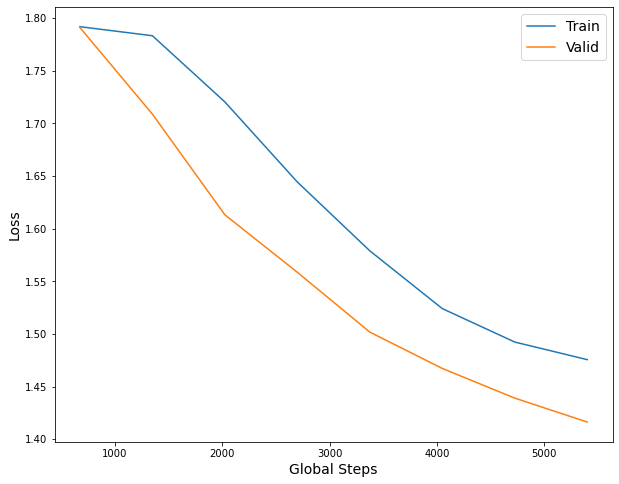

In [36]:
plt.figure(figsize=(10, 8))
train_loss_list, valid_loss_list, global_steps_list = load_metrics(output_path + '/metric.pkl')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [39]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (source, target), _ in test_loader:
                mask = (source != PAD_INDEX).type(torch.uint8)
                
                output = model(source, attention_mask=mask)

                y_pred.extend(torch.argmax(output, axis=-1).tolist())
                y_true.extend(target.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=range(len(categories)), target_names=categories, digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=range(len(categories)))
    ax = plt.subplot()

    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(categories)
    ax.yaxis.set_ticklabels(categories)

Classification Report:
               precision    recall  f1-score   support

  REMEMBERING     0.5228    0.7378    0.6120       450
UNDERSTANDING     0.7126    0.4133    0.5232       450
     APPLYING     0.5060    0.4667    0.4855       450
    ANALYZING     0.6396    0.4022    0.4939       450
   EVALUATING     0.4571    0.6756    0.5453       450
     CREATING     0.4785    0.4689    0.4736       450

     accuracy                         0.5274      2700
    macro avg     0.5528    0.5274    0.5223      2700
 weighted avg     0.5528    0.5274    0.5223      2700



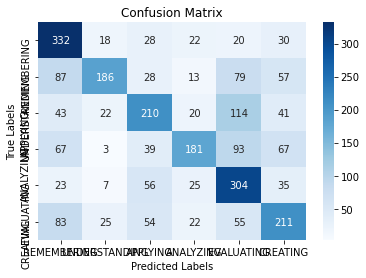

In [40]:
model_load = ROBERTAClassifier()
model_load = model_load.to(device)

load_checkpoint(output_path + '/model.pkl', model_load)

evaluate(model_load, valid_iter)

In [43]:
test_iter.dataset.fields.pop('PREDICT', None)

In [44]:
for a in test_iter:
    print(a)
    break


[torchtext.data.batch.Batch of size 16]
	[.QUERY]:[torch.cuda.LongTensor of size 16x256 (GPU 0)]


In [45]:
# Evaluation Function

def predict_test(model, test_loader):
    y_pred = []

    model.eval()
    with torch.no_grad():
        for (source), _ in test_loader:
                mask = (source != PAD_INDEX).type(torch.uint8)
                
                output = model(source, attention_mask=mask)

                y_pred.extend(torch.argmax(output, axis=-1).tolist())
    return y_pred

In [46]:
preds = predict_test(model_load, test_iter)

In [48]:
len(preds), test.shape[0]

(4500, 4500)

In [50]:
test["PREDICTED"] = preds
test.head()

,QUERY,PREDICT,PREDICTED
Id,,,
34985,is diffusion and osmosis used by the body syst...,3,5
39856,what is the difference between scalar and vect...,3,3
151591,can you do a proof on why the inverse function...,3,5
171241,"in the metaphase , how do the centrosomes push...",3,3
161682,what does k stand for ?,3,3


Classification Report:
               precision    recall  f1-score   support

  REMEMBERING     0.5128    0.7467    0.6080       750
UNDERSTANDING     0.6767    0.3880    0.4932       750
     APPLYING     0.5153    0.5160    0.5157       750
    ANALYZING     0.6299    0.3880    0.4802       750
   EVALUATING     0.4584    0.6467    0.5365       750
     CREATING     0.4837    0.4560    0.4695       750

     accuracy                         0.5236      4500
    macro avg     0.5461    0.5236    0.5172      4500
 weighted avg     0.5461    0.5236    0.5172      4500



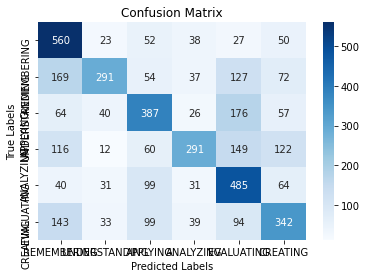

In [52]:
print('Classification Report:')
print(classification_report(test.PREDICT, test.PREDICTED, labels=range(len(categories)), target_names=categories, digits=4))

cm = confusion_matrix(test.PREDICT, test.PREDICTED, labels=range(len(categories)))
ax = plt.subplot()

sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(categories)
ax.yaxis.set_ticklabels(categories)
plt.show()

In [53]:
# Evaluation Function

def predict_proba(model, test_loader):
    y_pred = []

    model.eval()
    with torch.no_grad():
        for (source), _ in test_loader:
                mask = (source != PAD_INDEX).type(torch.uint8)
                
                output = model(source, attention_mask=mask)

                y_pred.extend(output.tolist())
    return y_pred

In [55]:
probs = predict_proba(model_load, test_iter)

In [56]:
len(probs)

4500

In [57]:
probs = np.array(probs)
probs.shape

(4500, 6)

In [58]:
test.head()

,QUERY,PREDICT,PREDICTED
Id,,,
34985,is diffusion and osmosis used by the body syst...,3,5
39856,what is the difference between scalar and vect...,3,3
151591,can you do a proof on why the inverse function...,3,5
171241,"in the metaphase , how do the centrosomes push...",3,3
161682,what does k stand for ?,3,3


In [59]:
df.head()

,QUERY,REMEMBERING,UNDERSTANDING,APPLYING,ANALYZING,EVALUATING,CREATING
Id,,,,,,,
0,"""their own language"" means _ .",1.0,0.0,0.0,0.0,0.0,0.0
1,"""you may think the popular singer jay chow is ...",0.0,1.0,0.0,0.0,0.0,0.0
2,". at midnight, nasreddin saw _ in his garden.",1.0,0.0,0.0,0.0,0.0,0.0
3,. david beckham is _ years old.,1.0,0.0,0.0,0.0,0.0,0.0
4,. david beckham's family name is _ and zhou...,1.0,0.0,0.0,0.0,0.0,0.0


In [60]:
y_test_true = df.loc[test.index][categories].values
y_test_true.shape

(4500, 6)

In [61]:
import metrics as m

In [62]:
m.get_performance_metrics(y_test_true, probs, categories)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,116,3635,115,634,0.834,0.167,0.155,0.969,0.502,0.851,0.858,0.236,0.5
UNDERSTANDING,215,3653,97,535,0.86,0.167,0.287,0.974,0.689,0.872,0.761,0.405,0.5
APPLYING,515,2818,932,235,0.741,0.167,0.687,0.751,0.356,0.923,0.803,0.469,0.5
ANALYZING,351,3508,242,399,0.858,0.167,0.468,0.935,0.592,0.898,0.81,0.523,0.5
EVALUATING,534,2985,765,216,0.782,0.167,0.712,0.796,0.411,0.933,0.827,0.521,0.5
CREATING,350,3278,472,400,0.806,0.167,0.467,0.874,0.426,0.891,0.762,0.445,0.5


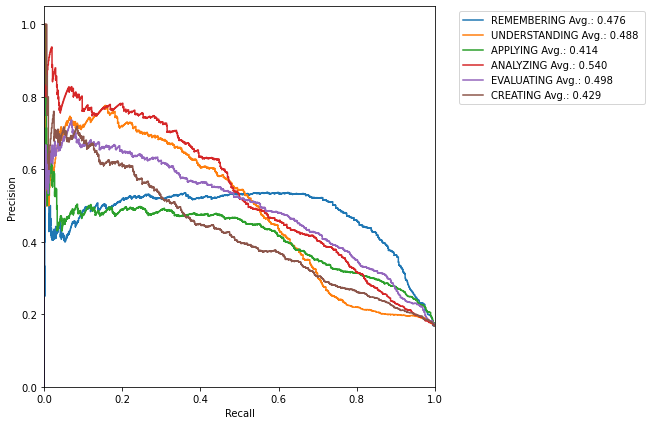

In [63]:
m.get_curve(y_test_true, probs, categories, curve='prc')